In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device: ", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [4]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

2021-12-24 11:43:11.832218: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
IMAGE_SIZE = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/127.5)-1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [7]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
monet_dataset = load_dataset(MONET_FILENAMES).batch(1)
photo_dataset = load_dataset(PHOTO_FILENAMES).batch(1)

2021-12-24 11:43:12.866373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:43:12.966159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:43:12.966914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 11:43:12.968233: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_dataset(MONET_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)

In [11]:
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

2021-12-24 11:43:15.795644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


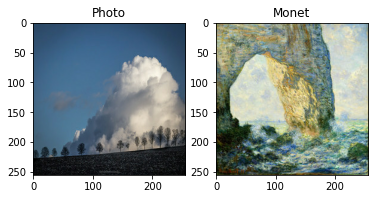

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
# plt.imshow(example_photo[0])

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
# plt.imshow(example_monet[0])

In [13]:
def prepare_dataset(monet_filenames, photo_filenames):
    
    monet_dataset = load_dataset(monet_filenames)
    photo_dataset = load_dataset(photo_filenames)  
        
#     monet_dataset = monet_dataset.shuffle(100000, seed=42)
#     photo_dataset = photo_dataset.shuffle(100000, seed=42)
    
    monet_dataset = monet_dataset.repeat()
    photo_dataset = photo_dataset.repeat()
    
#     monet_dataset = monet_dataset.batch(16)
#     photo_dataset = photo_dataset.batch(16)
    
    monet_dataset = monet_dataset.batch(4)
    photo_dataset = photo_dataset.batch(4)
    
    monet_dataset = monet_dataset.prefetch(AUTOTUNE)
    photo_dataset = photo_dataset.prefetch(AUTOTUNE)
    
    final_dataset = tf.data.Dataset.zip((monet_dataset, photo_dataset))
    
    return final_dataset

In [14]:
final_dataset = prepare_dataset(MONET_FILENAMES, PHOTO_FILENAMES)

In [15]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    
    
    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)
    fids=[]

87924736/87910968 [==============================] - 0s 0us/step


2021-12-24 11:43:23.024541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [16]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
  
        tr_covmean = tf.linalg.trace(covmean)

        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
    
    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
        inp = layers.Input(shape=[256, 256, 3], name='input_image')
        x  = gen_model(inp)
        x=inception_model(x)
        fid_model = tf.keras.Model(inputs=inp, outputs=x)

        mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)

        fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)


        return fid_value

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    model_down = tf.keras.Sequential()
    model_down.add(layers.Conv2D(filters, size, strides=2, padding='same', 
                                kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        model_down.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    model_down.add(layers.LeakyReLU())
    
    return model_down

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    model_up = tf.keras.Sequential()
    model_up.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', 
                                kernel_initializer=initializer, use_bias=False))
    
    model_up.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        model_up.add(layers.Dropout(0.5))
    
    model_up.add(layers.ReLU())
    
    return model_up   

In [19]:
def Generator():
    inputs = layers.Input([256,256,3])
    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', 
                                kernel_initializer=initializer, activation='tanh')
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)
    

In [20]:
Generator()

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    
    conv = layers.Conv2D(512, 4, strides=1, 
                        kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1, 4, strides=1, 
                        kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=inp, outputs=last)

In [22]:
Discriminator()

In [23]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

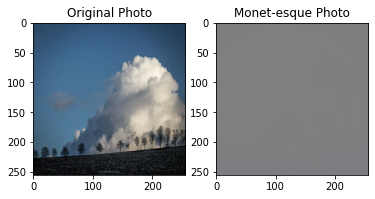

In [24]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [25]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator, 
        lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
    
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        aug_fn
        ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # With DiffAugment
            both_monet = tf.concat([real_monet, fake_monet], axis=0)
            aug_monet = self.aug_fn(both_monet)
#             print("HERE1")
            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]
#             print("HERE2")
            disc_real_monet = self.m_disc(aug_real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
        
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            total_monet_gen_loss = total_cycle_loss + monet_gen_loss + self.identity_loss_fn(real_monet,same_monet, self.lambda_cycle)
            total_photo_gen_loss = total_cycle_loss + photo_gen_loss + self.identity_loss_fn(real_photo,same_photo, self.lambda_cycle)
            
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables) 
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables) 
#         print("HERE4")
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables) 
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
#         print("HERE5")
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss":total_monet_gen_loss,
            "photo_gen_loss":total_photo_gen_loss,
            "monet_disc_loss":monet_disc_loss,
            "photo_disc_loss":photo_disc_loss
        }

In [26]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        
        generator_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        
        total_disc_loss = real_loss + generator_loss
        
        return 0.5*total_disc_loss

In [27]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [28]:
with strategy.scope():
    def cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA*(tf.reduce_mean(tf.abs(real_image-cycled_image)))

In [29]:
with strategy.scope():
    def identity_loss(real_image, gen_image, LAMBDA):
        return 0.5*LAMBDA*(tf.reduce_mean(tf.abs(real_image-gen_image)))

In [30]:
with strategy.scope():
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py

    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x
    
    
    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x
    
    
    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x
    
    
    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x
    
    
    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

In [31]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [32]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = cycle_loss,
        identity_loss_fn = identity_loss,
        aug_fn = aug_fn
    )

In [33]:
cycle_gan_model.fit(
    final_dataset, epochs=20, 
    steps_per_epoch=(max(n_monet_samples, n_photo_samples)//4)
)
FID(fid_photo_ds,monet_generator)

Epoch 1/20
1759/1759 [==============================] - 884s 479ms/step - monet_gen_loss: 3.7168 - photo_gen_loss: 4.1089 - monet_disc_loss: 0.6293 - photo_disc_loss: 0.5216
Epoch 2/20
1759/1759 [==============================] - 839s 477ms/step - monet_gen_loss: 2.8022 - photo_gen_loss: 3.0784 - monet_disc_loss: 0.6513 - photo_disc_loss: 0.5938
Epoch 3/20
1759/1759 [==============================] - 840s 477ms/step - monet_gen_loss: 2.5524 - photo_gen_loss: 2.7872 - monet_disc_loss: 0.6507 - photo_disc_loss: 0.5995
Epoch 4/20
1759/1759 [==============================] - 840s 477ms/step - monet_gen_loss: 2.4112 - photo_gen_loss: 2.6864 - monet_disc_loss: 0.6638 - photo_disc_loss: 0.5870
Epoch 5/20
1759/1759 [==============================] - 840s 478ms/step - monet_gen_loss: 2.3264 - photo_gen_loss: 2.6181 - monet_disc_loss: 0.6656 - photo_disc_loss: 0.5790
Epoch 6/20
1759/1759 [==============================] - 841s 478ms/step - monet_gen_loss: 2.2920 - photo_gen_loss: 2.6053 - monet_

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[11.37229]], dtype=float32)>

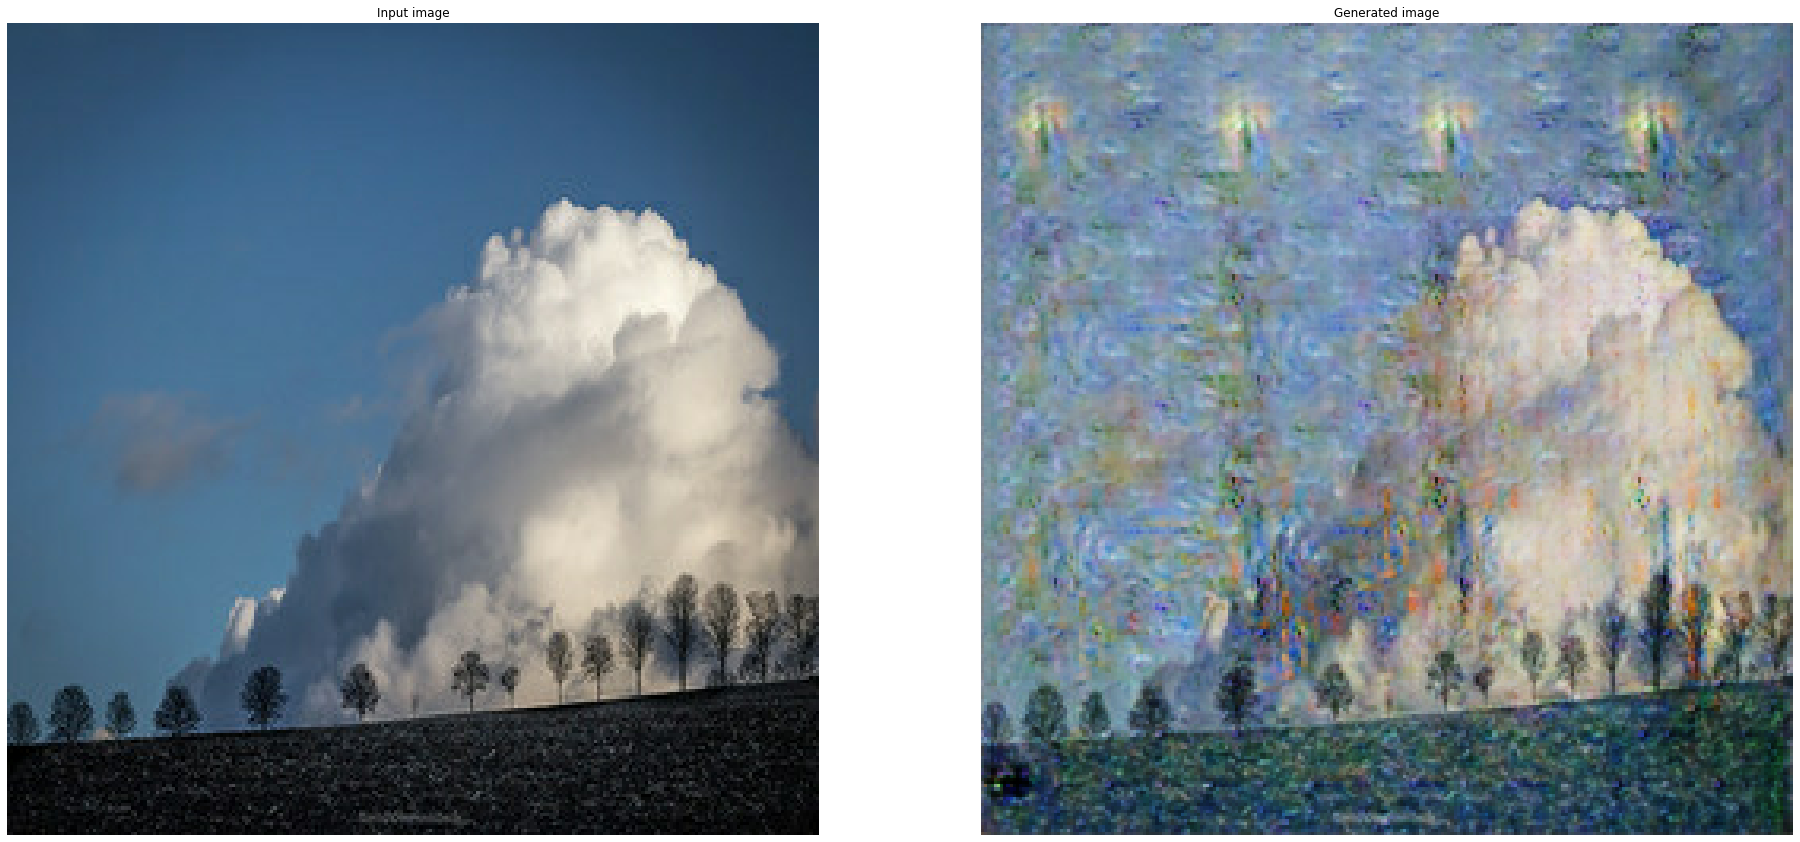

In [34]:
ds_iter = iter(photo_dataset)
for n_sample in range(1):
    example_sample = next(ds_iter)
    generated_sample = monet_generator(example_sample)
     
    f = plt.figure(figsize=(32, 32))
  
    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.axis('off')

    plt.subplot(122)
    plt.title('Generated image')
    plt.imshow(generated_sample[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()

In [35]:
import PIL
! mkdir ../images

In [36]:
i = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [37]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'